In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import xgboost
import optuna
from pickle import dump

##### Загрузка данных

In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
df.head()

,UserId,CreditScore,City,Gender,Age,Tenure,Balance,NumOfProducts,HasCredit,IsActiveUser,EstimatedSalary,Exited
0,15674932,668,Москва,Мужчина,33.0,3,0.0,2,True,False,90725.0,0
1,15749177,627,Москва,Мужчина,33.0,1,0.0,2,True,True,24752.0,0
2,15694510,678,Москва,Мужчина,40.0,10,0.0,2,True,False,92433.0,0
3,15741417,581,Москва,Мужчина,34.0,2,1488825.0,1,True,True,42280.0,0
4,15766172,716,Новосибирск,Мужчина,33.0,5,0.0,2,True,True,7534.0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   UserId           165034 non-null  int64  
 1   CreditScore      165034 non-null  int64  
 2   City             165034 non-null  object 
 3   Gender           165034 non-null  object 
 4   Age              165034 non-null  float64
 5   Tenure           165034 non-null  int64  
 6   Balance          165034 non-null  float64
 7   NumOfProducts    165034 non-null  int64  
 8   HasCredit        165034 non-null  bool   
 9   IsActiveUser     165034 non-null  bool   
 10  EstimatedSalary  165034 non-null  float64
 11  Exited           165034 non-null  int64  
dtypes: bool(2), float64(3), int64(5), object(2)
memory usage: 12.9+ MB


In [5]:
df.isna().sum()

UserId             0
CreditScore        0
City               0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCredit          0
IsActiveUser       0
EstimatedSalary    0
Exited             0
dtype: int64

In [6]:
df.nunique()

UserId             23221
CreditScore          457
City                   3
Gender                 2
Age                   71
Tenure                11
Balance            24614
NumOfProducts          4
HasCredit              2
IsActiveUser           2
EstimatedSalary    18807
Exited                 2
dtype: int64

In [7]:
df.duplicated().sum()

37

In [8]:
df = df.drop_duplicates()

##### Анализ графиков

In [9]:
plt.style.use('dark_background')

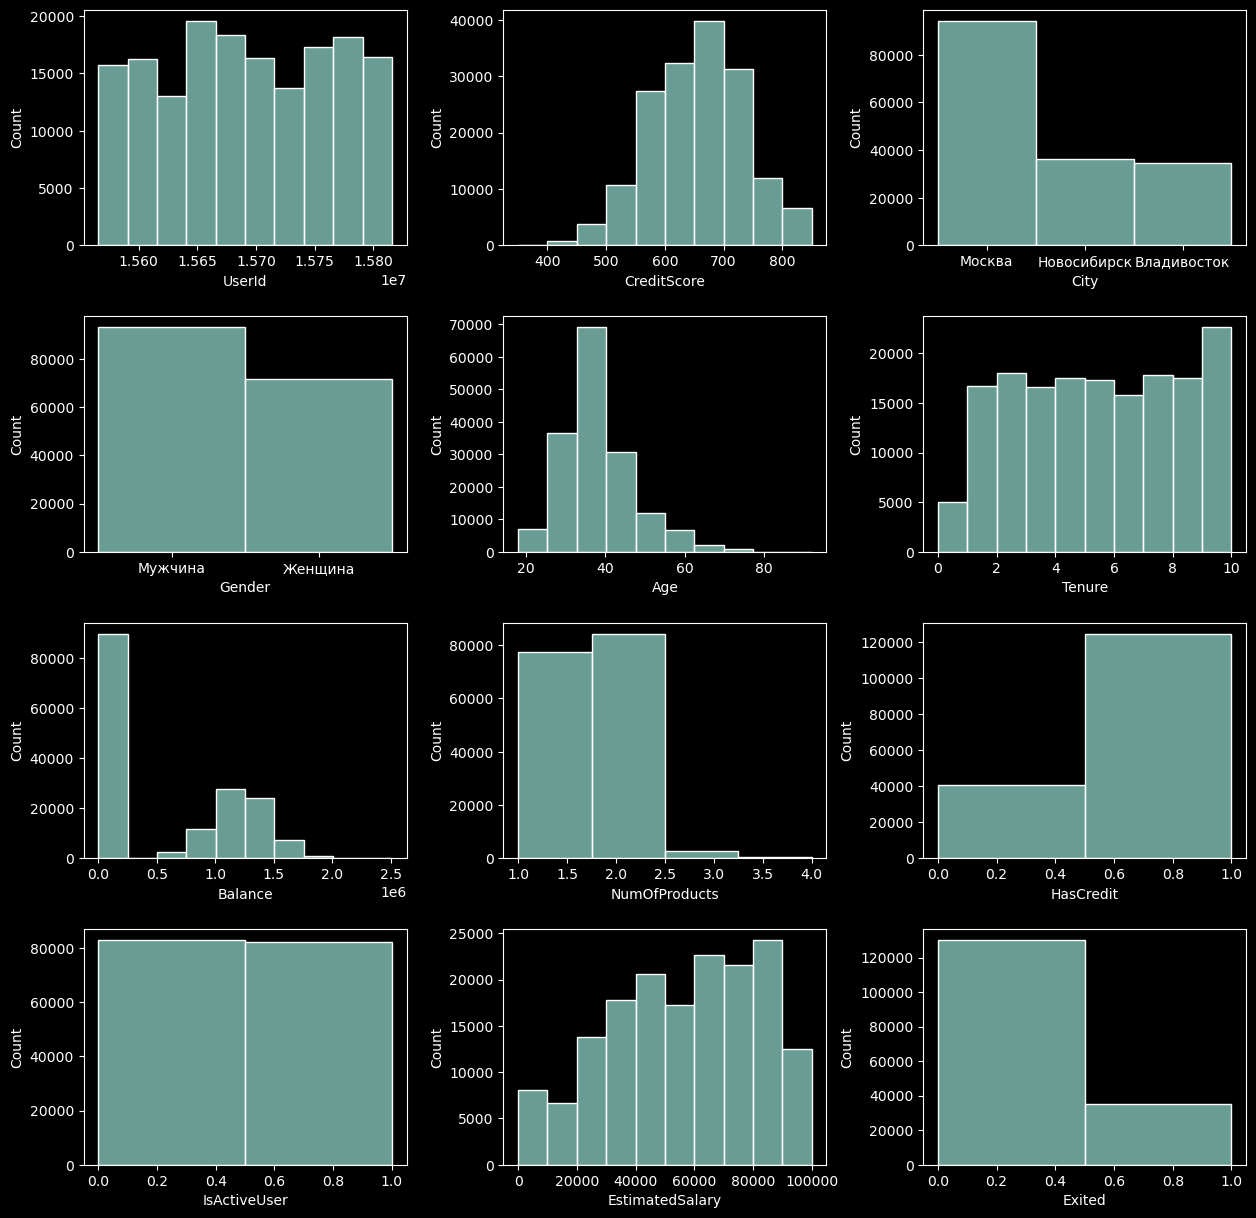

In [10]:
plt.figure(figsize=(15, 15))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
for i, column in enumerate(df.columns):
    n = df[column].nunique()
    bins = n if n < 10 else 10
    sns.histplot(data=df, x=column, bins=bins, ax=plt.subplot(4, 3, i + 1))

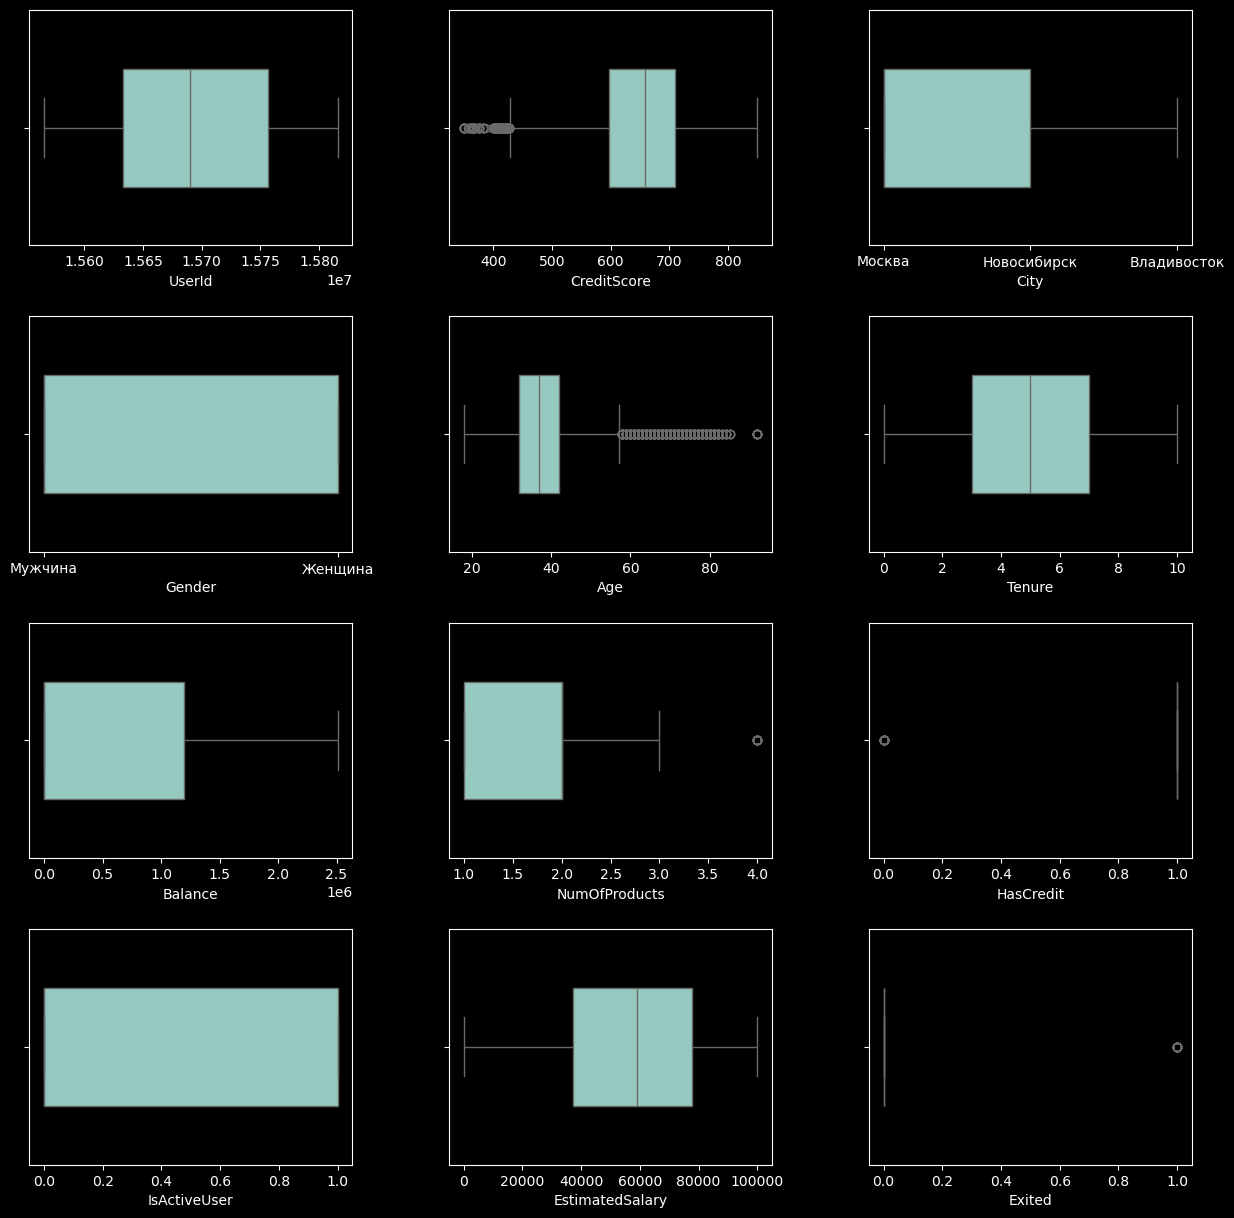

In [11]:
plt.figure(figsize=(15, 15))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
for i, column in enumerate(df.columns):
    sns.boxplot(data=df, x=column, width=0.5, ax=plt.subplot(4, 3, i + 1))

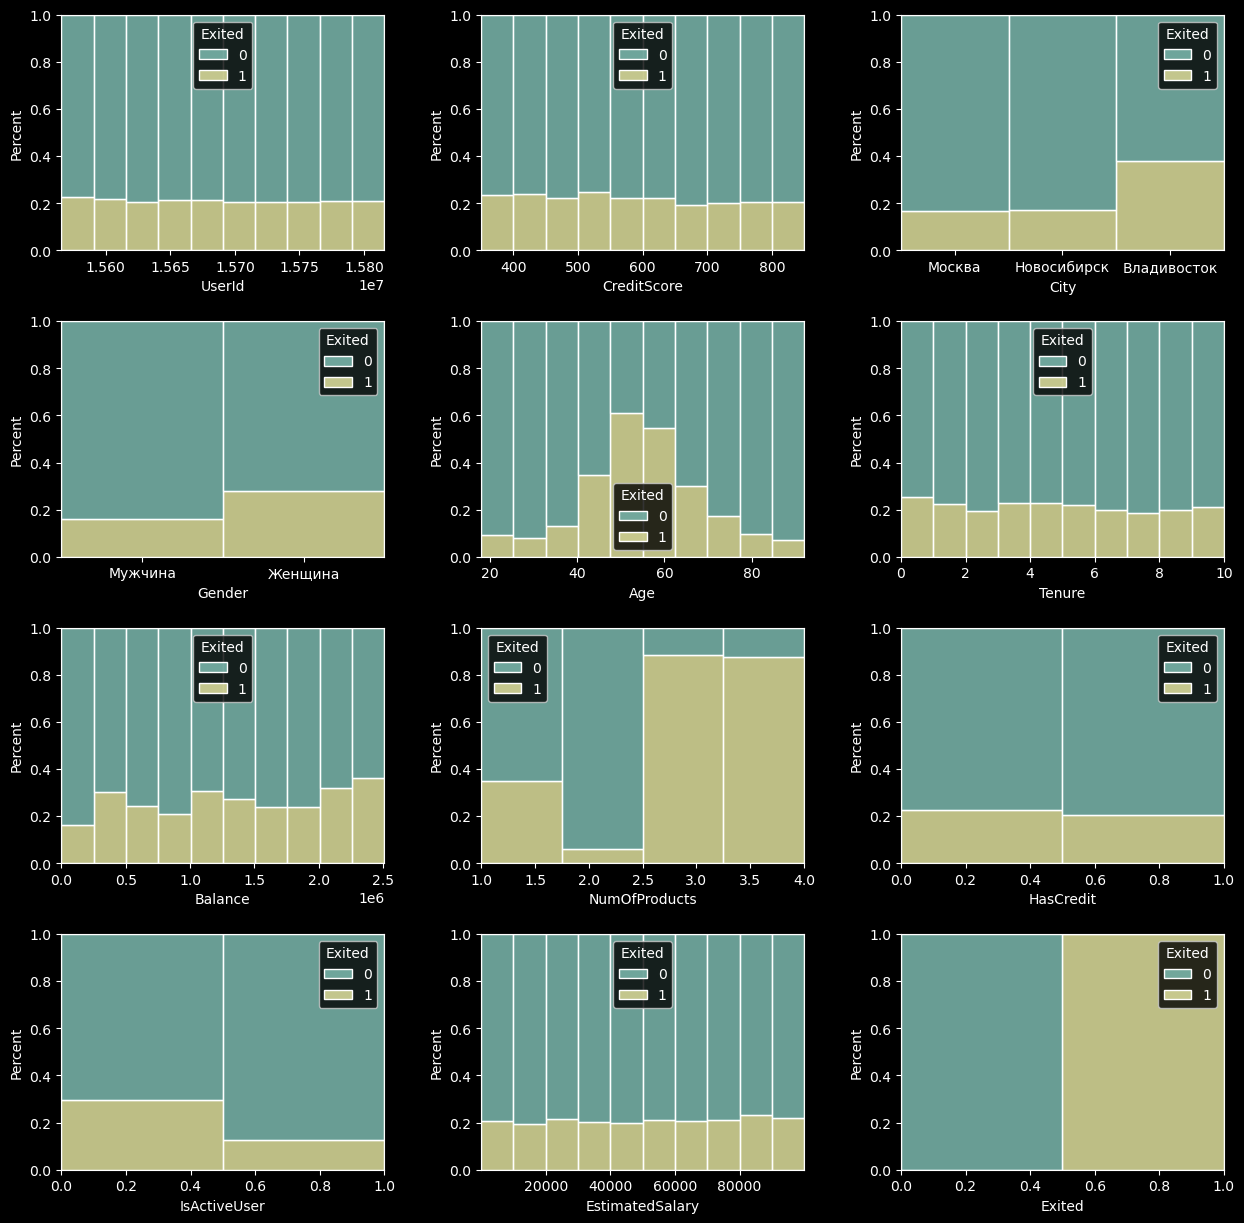

In [12]:
plt.figure(figsize=(15, 15))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
for i, column in enumerate(df.columns):
    n = df[column].nunique()
    bins = n if n < 10 else 10
    sns.histplot(data=df, x=column, bins=bins, hue='Exited', stat='percent', multiple='fill', ax=plt.subplot(4, 3, i + 1))

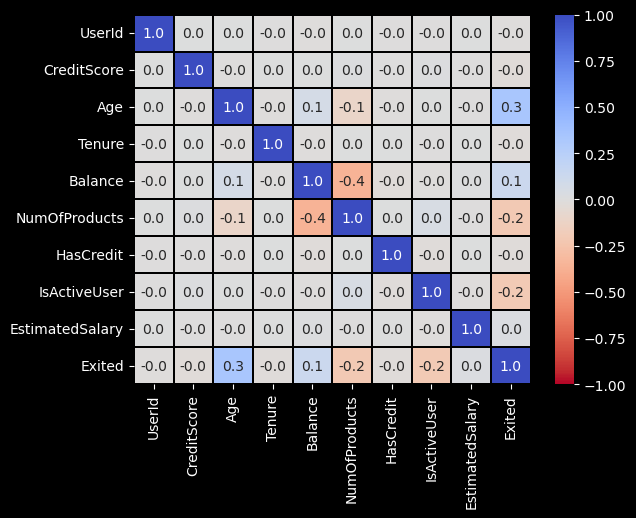

In [13]:
ax = sns.heatmap(data=df.corr(numeric_only=True), vmin=-1, vmax=1, cmap='coolwarm_r', annot=True, fmt='.1f', linecolor='k', linewidth=0.2)

##### Сплит данных

In [14]:
X = df.drop('Exited', axis=1)

In [15]:
y = df.Exited

In [16]:
X.City = pd.Categorical(X.City, ['Москва', 'Новосибирск', 'Владивосток'])

In [17]:
X.Gender = pd.Categorical(X.Gender, ['Мужчина', 'Женщина'])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

##### Базовая модель

In [19]:
clf = xgboost.XGBClassifier(objective='binary:logistic', enable_categorical=True)

In [20]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [21]:
roc_auc_score(y_true=y_train, y_score=clf.predict_proba(X_train)[:, 1])

0.9190065093879336

In [22]:
roc_auc_score(y_true=y_test, y_score=clf.predict_proba(X_test)[:, 1])

0.8850958695525921

In [23]:
pd.Series(clf.get_booster().get_score(importance_type='gain')).sort_values(ascending=False).round()

NumOfProducts      258.0
IsActiveUser        71.0
Age                 56.0
Gender              20.0
City                17.0
Balance             13.0
HasCredit            6.0
CreditScore          4.0
EstimatedSalary      4.0
UserId               4.0
Tenure               4.0
dtype: float64

##### Упрощенная модель

In [24]:
X_train_new = X_train[['NumOfProducts', 'IsActiveUser', 'Age', 'Gender', 'City', 'Balance']]

In [25]:
X_test_new = X_test[['NumOfProducts', 'IsActiveUser', 'Age', 'Gender', 'City', 'Balance']]

In [26]:
clf_new = xgboost.XGBClassifier(objective='binary:logistic', enable_categorical=True)

In [27]:
clf_new.fit(X_train_new, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [28]:
roc_auc_score(y_true=y_train, y_score=clf_new.predict_proba(X_train_new)[:, 1])

0.9016374782077495

In [29]:
roc_auc_score(y_true=y_test, y_score=clf_new.predict_proba(X_test_new)[:, 1])

0.8860803022793604

##### Настройка гиперпараметров

In [30]:
dtrain = xgboost.DMatrix(data=X_train_new, label=y_train, enable_categorical=True)

In [31]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eta': trial.suggest_float('eta', 0.05, 0.30, step=0.05),
        'max_depth': trial.suggest_int('max_depth', 3, 10, step=1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100, step=1),
        'subsample': trial.suggest_float('subsample', 0.50, 1.00, step=0.05),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.50, 1.00, step=0.05),
        'lambda': trial.suggest_float('lambda', 0.01, 100.00, log=True),
    }
    
    cv = xgboost.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=1000,
        early_stopping_rounds=50,
        nfold=5,
        stratified=True,
        seed=0,
        metrics='auc',
    )
    
    return cv.iloc[-1]['test-auc-mean']

In [32]:
study = optuna.create_study(study_name='optuna_study', direction='maximize')

[I 2024-09-26 15:34:15,461] A new study created in memory with name: optuna_study


In [33]:
study.optimize(objective, n_trials=10, n_jobs=-1, show_progress_bar=True)

  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-09-26 15:35:32,733] Trial 2 finished with value: 0.8875235655440864 and parameters: {'eta': 0.25, 'max_depth': 10, 'min_child_weight': 47, 'subsample': 0.6, 'colsample_bytree': 0.8500000000000001, 'lambda': 0.9105679747568209}. Best is trial 2 with value: 0.8875235655440864.
[I 2024-09-26 15:35:43,383] Trial 1 finished with value: 0.8884514793668208 and parameters: {'eta': 0.3, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.9, 'colsample_bytree': 0.65, 'lambda': 12.45012725988707}. Best is trial 1 with value: 0.8884514793668208.
[I 2024-09-26 15:35:45,279] Trial 0 finished with value: 0.8879810182705571 and parameters: {'eta': 0.2, 'max_depth': 7, 'min_child_weight': 93, 'subsample': 1.0, 'colsample_bytree': 0.9, 'lambda': 0.03478583911174217}. Best is trial 1 with value: 0.8884514793668208.
[I 2024-09-26 15:35:49,006] Trial 3 finished with value: 0.8876831765918043 and parameters: {'eta': 0.15000000000000002, 'max_depth': 9, 'min_child_weight': 24, 'subsample': 1.0, 'co

In [34]:
best_params = study.best_params
best_params

{'eta': 0.3,
 'max_depth': 5,
 'min_child_weight': 8,
 'subsample': 0.9,
 'colsample_bytree': 0.65,
 'lambda': 12.45012725988707}

In [35]:
cv = xgboost.cv(
    params={**{'objective': 'binary:logistic'}, **best_params},
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=50,
    nfold=5,
    stratified=True,
    seed=0,
    metrics='auc',
)

In [36]:
cv.tail()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
54,0.891638,0.000550,0.888448,0.002288
55,0.891635,0.000550,0.888449,0.002288
56,0.891639,0.000551,0.888444,0.002288
57,0.891676,0.000561,0.888436,0.002288
58,0.891700,0.000563,0.888451,0.002278


In [37]:
best_round = len(cv)
best_round

59

In [38]:
clf_new.n_estimators=best_round
clf_new.learning_rate=best_params['eta']
clf_new.max_depth=best_params['max_depth']
clf_new.min_child_weight=best_params['min_child_weight']
clf_new.subsample=best_params['subsample']
clf_new.colsample_bytree=best_params['colsample_bytree']
clf_new.reg_lambda=best_params['lambda']

In [39]:
clf_new.fit(X_train_new, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.65, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=59, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [40]:
roc_auc_score(y_true=y_train, y_score=clf_new.predict_proba(X_train_new)[:, 1])

0.8913963436256134

In [41]:
roc_auc_score(y_true=y_test, y_score=clf_new.predict_proba(X_test_new)[:, 1])

0.8875001540511156

In [42]:
pd.Series(clf_new.get_booster().get_score(importance_type='gain')).sort_values(ascending=False).round()

NumOfProducts    276.0
IsActiveUser     136.0
Age               94.0
City              52.0
Gender            35.0
Balance           15.0
dtype: float64

##### Оценка модели

In [43]:
y_score = cross_val_predict(clf_new, X_train_new, y_train, n_jobs=-1, method='predict_proba')

In [44]:
y_score = y_score[:, 1]

In [57]:
roc_auc_score(y_true=y_train, y_score=y_score)

0.8884155863972889

In [45]:
cm = confusion_matrix(y_train, y_score > 0.5)

In [46]:
cm

array([[98783,  5283],
       [12450, 15481]])

In [47]:
cm[0, 1] / (cm[0, 1] + cm[0, 0])

0.050765860127226954

In [48]:
cm[1, 1] / (cm[1, 1] + cm[1, 0])

0.5542587089613691

In [49]:
fpr, tpr, thresholds = roc_curve(y_train, y_score)

In [50]:
idx = np.argmin(np.abs(thresholds - 0.5))

In [51]:
fpr[idx]

0.05077546941364134

In [52]:
tpr[idx]

0.5542587089613691

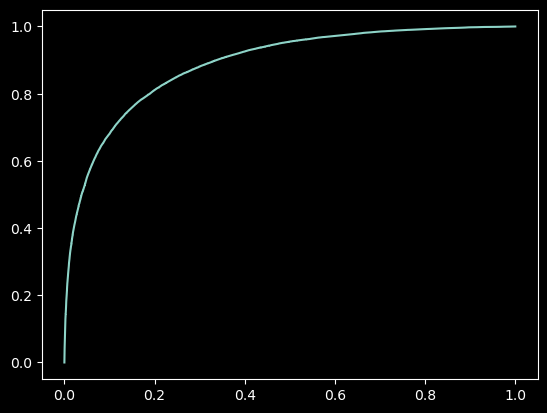

In [53]:
ax = plt.plot(fpr, tpr)

In [54]:
preds_df = pd.DataFrame({'y_true': y_train, 'y_pred': y_score})

In [55]:
preds_df.to_csv('data/preds.csv', index=False)

In [56]:
with open('data/model.pkl', 'wb') as f:
    dump(clf_new, f, protocol=5)